In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_pdf

In [2]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [3]:
import seaborn as sns

cm = sns.light_palette("purple", as_cmap=True)

exp = "GAS-001"
df = pd.read_excel(f'./final/{exp}/XRD+synthsis_data.xlsx') 

path = Path(f"./final/{exp}/unroll_new/raqnehvi/0/")


df = df[
    [
        "Sample ID",
        "id",
        "pH",
        "C_ZnCl",
        "C_NaOH/C_ZnCl",
        "C_NaOH",
        # "End",
        "Cond",
        "Aspect Ratio",
        "Peak Ratio",
        # "00n Size",
        # "Isotropic Size",
        # "2theta 1",
        # "2theta 2",
        # "2theta 3",
        # "2theta 4",
        # "Int. 1",
        # "Int. 2",
        # "Int. 3",
        # "Int. 4",
        # "Net Height_1",
        # "Net Height_2",
        # "Net Height_3",
        # "Net Height_4",
        # "pressure_air_std",
        # "pressure_b_std",
        # "pressure_b_mean",
        # "pressure_a_std",
        # "pressure_a_mean",
    ]
]
df.dropna(how="any", axis=1, inplace=True)

# only where C_NaOH/C_ZnCl is bigger than 1.6
df["initial_sampling"] = df["id"] < 12
df.reset_index(drop=True, inplace=True)


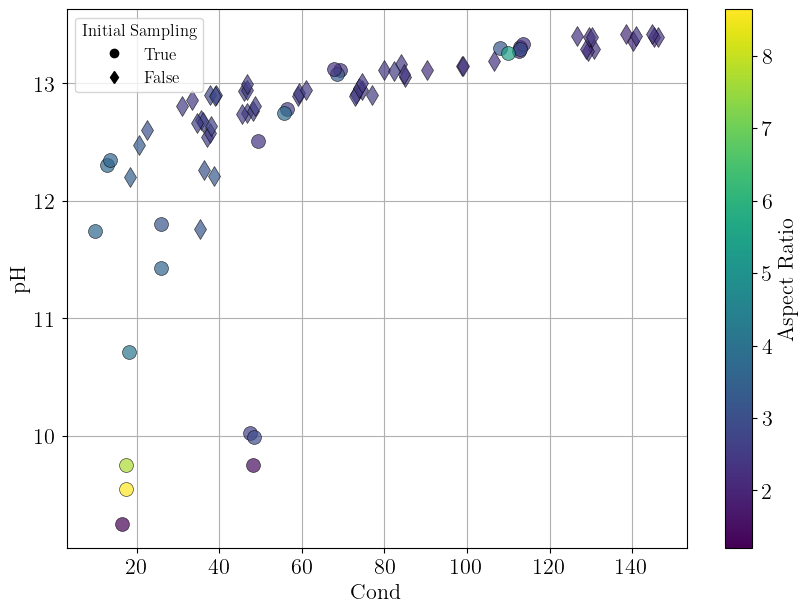

In [5]:
# %config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        # font size
        "font.size": 16,
    }
)
def is_float_column(column, df):
    return df[column].dtype in [np.float64, np.float32]

def get_color(column, df):
    labels = df[column]
    if is_float_column(column, df):
        # Use a continuous colormap for float-valued columns
        norm = plt.Normalize(labels.min(), labels.max())
        cmap = plt.cm.viridis
        colors = cmap(norm(labels))
    else:
        # Use distinct colors for category or integer-valued columns
        unique_labels = np.unique(labels)
        cmap = plt.cm.tab10
        colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
        colors = np.array([colors_dict[label] for label in labels])
        
    return colors

def scatter_plot(df, x, y, cc, mc, filter_data=""):

    if filter_data == "filter":
        df = df[df["C_NaOH/C_ZnCl"] > 1.6]
        
    colors = get_color(cc, df)
    colors_dict = {label: colors[i] for i, label in enumerate(df[cc].unique())}

    markers_all = ["o", "d"]
    markers_dict = {label: markers_all[idx % len(markers_all)] for idx, label in enumerate(df[mc].unique())}
    markers = [markers_dict[label] for label in df[mc]]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    for i in range(df.shape[0]):
        row = df.iloc[i]
        color = colors[i]
        marker = markers[i]
        sc=ax.plot(
            row[x],
            row[y],
            marker=marker,
            color=color,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="black",
            alpha=.7,
        )
        
    for m in df[mc].unique():
        ax.plot([], [], marker=markers_dict[m], color="k", label=m, linestyle="None")
        
    # for c in df[cc].unique():
    #     ax.plot([], [], marker="o", color=colors_dict[c], label=f"{cc}: {c}", linestyle="None")

    ax.legend(fontsize=12, title_fontsize=12, title="Initial Sampling")

    # custom colorbar
    if is_float_column(cc, df):
        # Add a colorbar if 'cc' is a float column
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df[cc].min(), vmax=df[cc].max()))
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label=cc)


    ax.set_xlabel(x)
    ax.set_ylabel(y) 
    ax.grid(True)
    
    return fig, ax

columns = df.columns

filter_data = "filter"
# filter_data = ""
cc = "Aspect Ratio"
x = "Cond"
# cc = "zero"
# y = "Aspect Ratio_VaR"
# x = "C_NaOH/C_ZnCl"
y = "pH"
mc = "initial_sampling"

fig, ax = scatter_plot(df, x, y, cc, mc, filter_data)

path = Path(f"figures/aa")

save_pdf(fig, path,f"{exp}/raw/{cc}/{mc}", f"{x}+{y}+{cc}+{mc}+{filter_data}".replace("/", "_"))